In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [349]:
df_full = pd.read_csv('take-home_exercise_data.csv')
df = df_full.copy()

Cleaning and Preprocessing


In [351]:
#checking null values and column types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251942 entries, 0 to 251941
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               251942 non-null  int64  
 1   prospectid               251942 non-null  int64  
 2   ordernumber              251942 non-null  int64  
 3   ordercreatedate          251942 non-null  object 
 4   regtenure                251942 non-null  object 
 5   customer_type_group      251942 non-null  object 
 6   dnatestactivationdayid   178845 non-null  object 
 7   daystogetresult_grp      251942 non-null  object 
 8   dna_visittrafficsubtype  189093 non-null  object 
 9   xsell_gsa                251942 non-null  int64  
 10  xsell_day_exact          40579 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 21.1+ MB


In [352]:
#seeing how many are 1(meaning they became new subscriber)
xsell = df['xsell_gsa'].value_counts()
print(xsell)

xsell_gsa
0    211363
1     40579
Name: count, dtype: int64


In [353]:
#Use this only to observe costumers that ended up subscribing (dropping those that did not did not)
# df = df.dropna(subset=['xsell_day_exact'])

In [354]:
#dropping first column
df.drop("Unnamed: 0", axis=1, inplace=True)

Cleaning ordercreatedate

In [355]:
#converting column to datetime format
df['ordercreatedate'] = pd.to_datetime(df['ordercreatedate'])


In [356]:
df['ordercreatedate'].describe()

count                           251942
mean     2015-12-28 11:47:40.286891520
min                1900-01-01 00:00:00
25%                2015-06-09 00:00:00
50%                2016-05-11 00:00:00
75%                2016-11-28 00:00:00
max                2017-04-02 00:00:00
Name: ordercreatedate, dtype: object

In [357]:
filtered_df = df[df['ordercreatedate'].dt.year < 1950]

print(filtered_df)

        prospectid  ordernumber ordercreatedate    regtenure  \
3029     155297138    140337214      1900-01-01  No Reg Date   
4276      84408881    141609021      1900-01-01  No Reg Date   
7941      24456464    133526400      1900-01-01  No Reg Date   
12833    158981531    143367592      1900-01-01  No Reg Date   
61488    151633694    134016837      1900-01-01  No Reg Date   
73340    162579443    146559202      1900-01-01  No Reg Date   
96449     50140549    131986830      1900-01-01  No Reg Date   
144280   106697222    132552046      1900-01-01  No Reg Date   
165863   102066828    142099849      1900-01-01  No Reg Date   
182913   147348606    137070982      1900-01-01  No Reg Date   
182985    12642581    130389156      1900-01-01  No Reg Date   
243767    94394792    134458593      1900-01-01  No Reg Date   

       customer_type_group dnatestactivationdayid daystogetresult_grp  \
3029               New Reg             2015-11-25             5 weeks   
4276               Ne

In [358]:
df.loc[df['ordercreatedate'] == '1900-01-01', 'ordercreatedate'] = '2015-01-01'

In [359]:
#separating order date
df['order_year'] = df['ordercreatedate'].dt.year
df['order_month'] = df['ordercreatedate'].dt.month
df['order_day'] = df['ordercreatedate'].dt.day
#feature engineer to see if purchase was made on weekend
df['is_weekend'] = (df['ordercreatedate'].dt.dayofweek >= 5).astype(int)

In [360]:
#checking unique values of regtenure
df['regtenure'].unique()

array(['More than 120 days old', 'Order prior to reg', '<=60 days',
       '<=120 days', '<=10 days', '<=30 days', '<=20 day', 'No Reg Date',
       '<=90 days'], dtype=object)

In [361]:
#one hot encoding for regtenure
df['regtenure'] = df['regtenure'].astype(str)
dummy_variables = pd.get_dummies(df['regtenure'], prefix='regtenure')
dummy_variables = dummy_variables.astype(int)
df = pd.concat([df, dummy_variables], axis=1)

In [362]:
#label encoding regtenure
le = LabelEncoder()
df['regtenure'] = le.fit_transform(df['regtenure'])

In [363]:
#checking unique values for customer type
df['customer_type_group'].unique()

array(['Existing Reg', 'New Reg', 'Acom Sub'], dtype=object)

In [364]:
#one hot encoding for non ordinal relationship 
dummy_variables = pd.get_dummies(df['customer_type_group'], prefix='customer_type_group')
dummy_variables = dummy_variables.astype(int)
df = pd.concat([df, dummy_variables], axis=1)

In [365]:
#response variable conditions
df['cross_sell'] = (df['xsell_gsa'] == 1) & (df['xsell_day_exact'] <= 120)
df['cross_sell'] = df['cross_sell'].astype(int)

In [366]:
df['dnatestactivationdayid'] = pd.to_datetime(df['dnatestactivationdayid'])
#separating order date
df['activation_year'] = df['dnatestactivationdayid'].dt.year
df['activation_month'] = df['dnatestactivationdayid'].dt.month
df['activation_day'] = df['dnatestactivationdayid'].dt.day
#feature engineer to see if activation was made on weekend
df['is_weekend_a'] = (df['dnatestactivationdayid'].dt.dayofweek >= 5).astype(int)

In [367]:
#-1 for rows with no activation date
columns_to_replace = ['activation_year', 'activation_month', 'activation_day']
df[columns_to_replace] = df[columns_to_replace].fillna(-1)

In [368]:
#Creating days between order and activation column
df['activation_minus_order'] = (df['dnatestactivationdayid'] - df['ordercreatedate']).dt.days
#For rows where activation date is missing, set the value -1
df.loc[df['dnatestactivationdayid'].isna(), 'activation_minus_order'] = -1

In [369]:
df['daystogetresult_grp'].unique()

array(['4 weeks', '-1', '6 weeks', '5 weeks', '3 weeks', '7 weeks',
       '10 weeks', '2 weeks', '>10weeks', '9 weeks', '8 weeks', '1 week'],
      dtype=object)

In [370]:
#one hot encoding for days to get result, -1 is did not activate column
df['daystogetresult_grp'] = df['daystogetresult_grp'].replace('-1', 'did_not_activate')
df_encoded = pd.get_dummies(df['daystogetresult_grp'], prefix='result_grp')
df_encoded = df_encoded.astype(int)
df = pd.concat([df, df_encoded], axis=1)

In [371]:
df['dna_visittrafficsubtype'].unique()

array([nan, 'Paid Search Non Brand', 'Email Programs',
       'email no source id', 'direct non-homepage', 'Email Campaigns',
       'direct dna homepage', 'direct core homepage', 'geo-redirect',
       'paid search – dna brand', 'organic dna brand',
       'internal referrals', 'paid search – core brand',
       'Affiliate External', 'organic core brand', 'External Paid Media',
       'content marketing', 'organic nonbrand', 'Radio Brand/PR',
       'Paid Search GDN ', 'social media organic', 'iOS App', 'Inbound',
       'external referrals', 'FindAGrave', 'Direct Mail',
       'FTM Software Integration', 'Social', 'Web Property', 'Search',
       'Partners', 'Direct', 'Digital Video',
       'Telemarketing Other (short term 8/31/05)', 'Windows App',
       'TV Brand/PR', 'External Email', 'DNA App', 'Mobile',
       'Android App', 'Social Media Natural ', 'Feeders', 'Display',
       'Library/Assoc.', 'Biz Dev', 'Overlays', 'Kiosk'], dtype=object)

In [372]:
#dummy variables for traffic type
df['dna_visittrafficsubtype'] = df['dna_visittrafficsubtype'].replace('NaN', 'None')
df_encoded = pd.get_dummies(df['dna_visittrafficsubtype'], prefix='')
df_encoded = df_encoded.astype(int)
df = pd.concat([df, df_encoded], axis=1)

In [373]:
#counts for response variable
cross_sell_counts = df['cross_sell'].value_counts()
print(cross_sell_counts)

cross_sell
0    220726
1     31216
Name: count, dtype: int64


Creating Visualizations for Initial Analysis

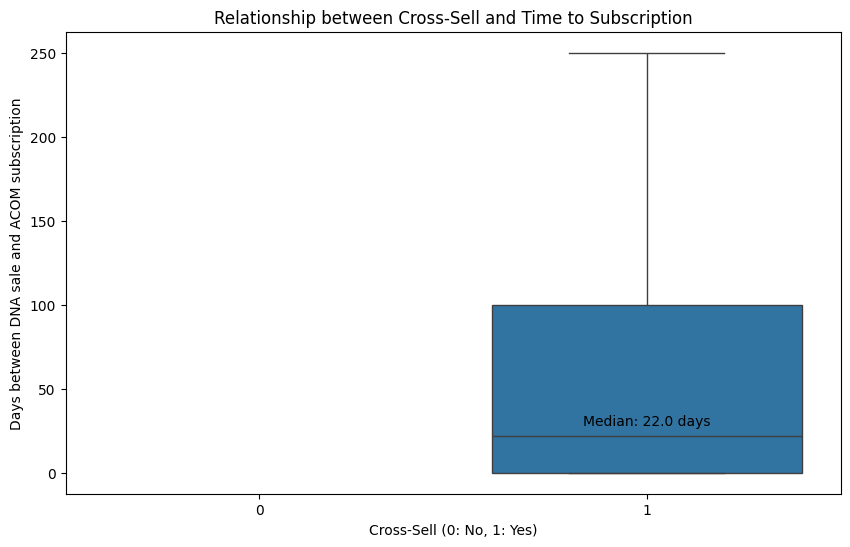

In [305]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='xsell_gsa', y='xsell_day_exact', data=df, showfliers=False)
#adding median annotations
medians = df.groupby('xsell_gsa')['xsell_day_exact'].median().values
#finding and displaying median
for tick, label in enumerate(ax.get_xticklabels()):
    ax.annotate(f'Median: {medians[tick]} days',
                (tick, medians[tick]),
                textcoords="offset points",
                xytext=(0,5),
                ha='center', va='bottom')
#labels and title
plt.xlabel('Cross-Sell (0: No, 1: Yes)')
plt.ylabel('Days between DNA sale and ACOM subscription')
plt.title('Relationship between Cross-Sell and Time to Subscription')
plt.show()

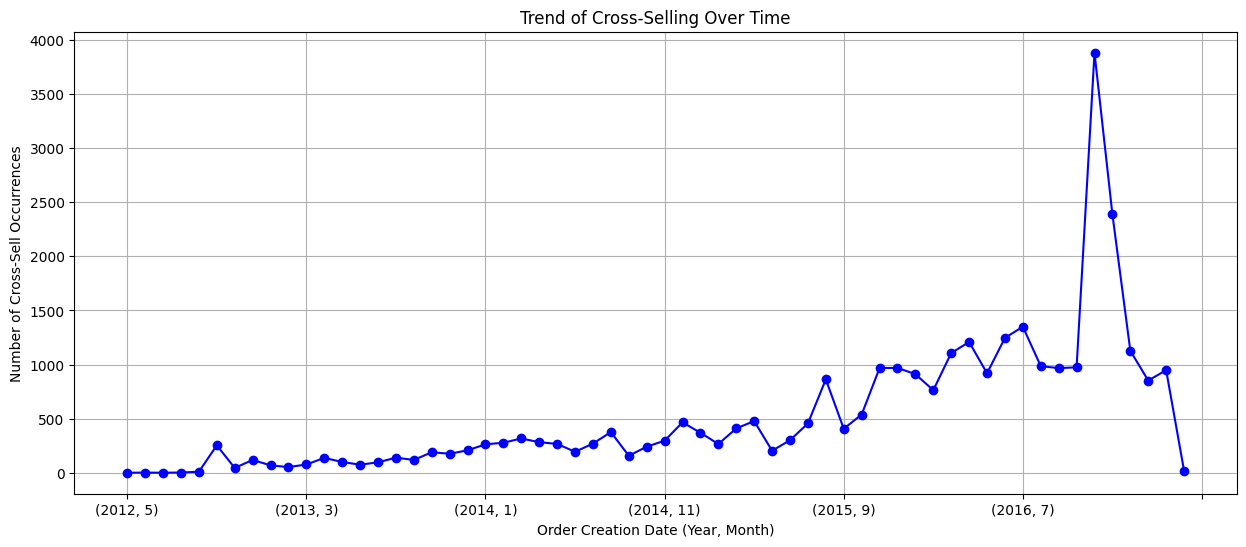

In [318]:
#count the number of cross-sell occurrences for each day
cross_sell_counts = df[df['cross_sell'] == 1].groupby(['order_year', 'order_month']).size()
plt.figure(figsize=(15, 6))
cross_sell_counts.plot(marker='o', linestyle='-', color='b')

plt.xlabel('Order Creation Date (Year, Month)')
plt.ylabel('Number of Cross-Sell Occurrences')
plt.title('Trend of Cross-Selling Over Time')
plt.grid(True)
plt.show()

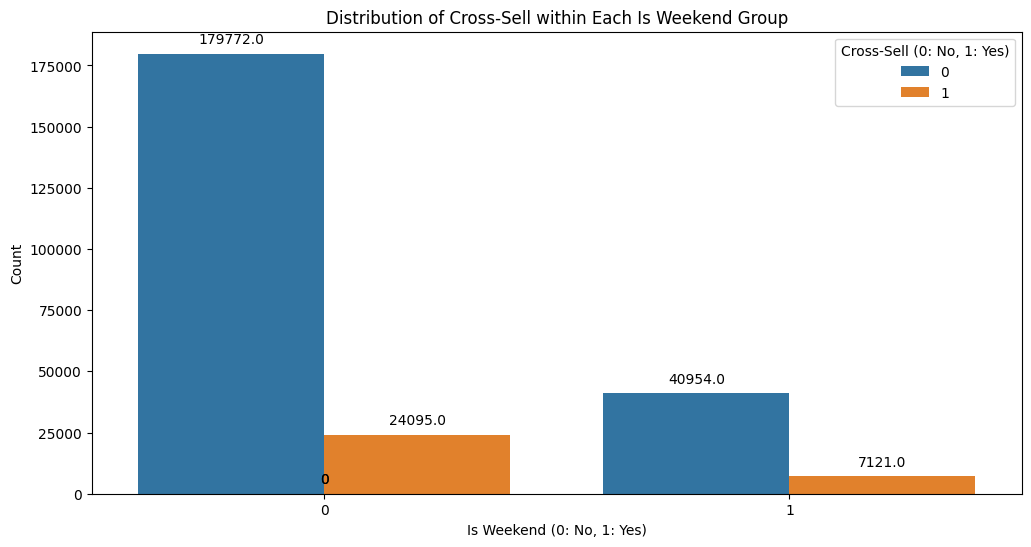

In [331]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(x='is_weekend_a', hue='cross_sell', data=df)

plt.xlabel('Is Weekend (0: No, 1: Yes)')
plt.ylabel('Count')
plt.title('Distribution of Cross-Sell within Each Is Weekend Group')

#show the counts on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax.grid(False)
plt.legend(title='Cross-Sell (0: No, 1: Yes)')
plt.show()

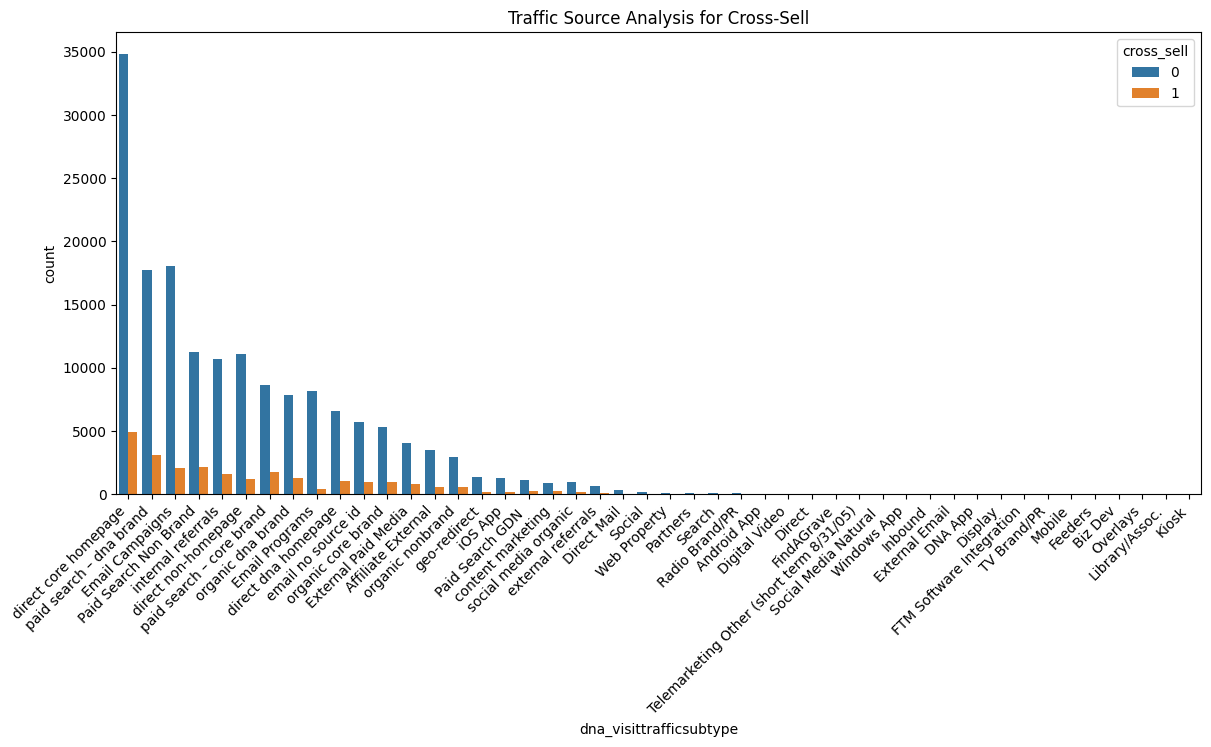

In [319]:
plt.figure(figsize=(14, 6))
sns.countplot(x='dna_visittrafficsubtype', data=df, hue='cross_sell', order=df['dna_visittrafficsubtype'].value_counts().index)
plt.title('Traffic Source Analysis for Cross-Sell')
plt.xticks(rotation=45, ha='right')
plt.show()

In [320]:
fraction_cross_sell = df['cross_sell'].sum() / len(df)
print(f'Fraction of customers who cross-sell to subscription: {fraction_cross_sell:.2%}')

Fraction of customers who cross-sell to subscription: 12.39%


In [377]:
#dropping columns that were used for feature engineering
df = df.drop(['customer_type_group'], axis=1)
df = df.drop(['dnatestactivationdayid'], axis=1)
df = df.drop(['ordercreatedate'], axis=1)
df = df.drop('daystogetresult_grp', axis=1)
df = df.drop('dna_visittrafficsubtype', axis=1)
df = df.drop(['xsell_gsa', 'xsell_day_exact'], axis=1)

In [378]:
#Checking for nan
rows_with_nan = df[df.isna().any(axis=1)]
print(rows_with_nan)

Rows with NaN values:
Empty DataFrame
Columns: [prospectid, ordernumber, regtenure, order_year, order_month, order_day, is_weekend, regtenure_<=10 days, regtenure_<=120 days, regtenure_<=20 day, regtenure_<=30 days, regtenure_<=60 days, regtenure_<=90 days, regtenure_More than 120 days old, regtenure_No Reg Date, regtenure_Order prior to reg, customer_type_group_Acom Sub, customer_type_group_Existing Reg, customer_type_group_New Reg, cross_sell, activation_year, activation_month, activation_day, is_weekend_a, activation_minus_order, result_grp_1 week, result_grp_10 weeks, result_grp_2 weeks, result_grp_3 weeks, result_grp_4 weeks, result_grp_5 weeks, result_grp_6 weeks, result_grp_7 weeks, result_grp_8 weeks, result_grp_9 weeks, result_grp_>10weeks, result_grp_did_not_activate, _Affiliate External, _Android App, _Biz Dev, _DNA App, _Digital Video, _Direct, _Direct Mail, _Display, _Email Campaigns, _Email Programs, _External Email, _External Paid Media, _FTM Software Integration, _Feede